# QBUS2820 Assignment 2

**SID:** 510575452

In [2]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error

# Executive Summary

The project requirements aims to develop a time series model to forecast the Consumer Price Index (CPI) using data given to us that consists of 100 entries ranging from quarterly periods from March 1997 to December 2021.  The main objective is to predict the CPI values for March 2022 to December 2023 using multiple-step-ahead approaches.  Having accurate CPI forecasts is essential for economic and financial decision making.  

The analysis begins with Exploratory Data Analysis (EDA), observing initial data, seasonal patterns, and autocorrelation structures within the dataset. Key EDA elements include trend analysis, seasonal plots to assess yearly patterns, and ACF/PCF plots for data dependency.

For model development, we explored several techniques, including time series decomposition and stationarity testing (ADF), before focusing on a selection of models: SARIMA and various exponential smoothing methods (Simple Exponential Smoothing, Holt, and Holt-Winters variations). 

Model validation is conducted using an expanding window split approach to identify the most accurate forecast method based on the lowest Mean Squared Error (MSE).

The results indicate that the SARIMA model, based on AIC selection, is the best performing model for this forecast. The final SARIMA (AIC) model will be utilised to provide reliable CPI projections for decision-making applications.

# Loading in Dataset

## Raw Data

In [3]:
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

CPI_train_data

,CPI
Quarter,
Mar-97,94.5
Jun-97,93.1
Sep-97,95.4
Dec-97,96.3
Mar-98,96.0
...,...
Dec-20,125.3
Mar-21,123.6
Jun-21,124.5


**Note:**

- There are 100 entries


- Shows each quarter from 1997 - 2021


- Date layout: `<abbreviation_of_month>-yy`

# Data Cleaning

## Parsed Data

In [4]:
CPI_train_data.index = pd.to_datetime(
    CPI_train_data.index, format='%b-%y', errors='coerce')

CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


Data is parsed so that the index of `CPI_Train_data` is converted into a quarterly period index format instead of `<abbreviation_of_month>-yy` format. This will make the analysis consistent with the data provided and easier to apply to time series related libraries.

## Looking at Key Characteristics of the dataset

In [5]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


Checking that it starts from the first quarter in 1997 as specified in the assignment specifications of the dataset.

In [6]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


Checking that it ends at the last quarter in 2021 as specified in the assignment specifications of the dataset.

In [7]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

Only variable that we are dealing with is `CPI` which will be used to forecast the next 8 periods of the CPI data set.

In [8]:
CPI_train_data.shape

(100, 1)

There are 100 rows by 1 column.

### Removing null values

In [9]:
clean_CPI_train_data = CPI_train_data.dropna()

**Note:** even though there are no null values, it is great practice to always include this step in the data cleaning phase.

## Looking at the information of the dataset

In [10]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [11]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [12]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

This is to verify that there are no null values in the CPI dataset.

# EDA

## Looking at the initial of the data

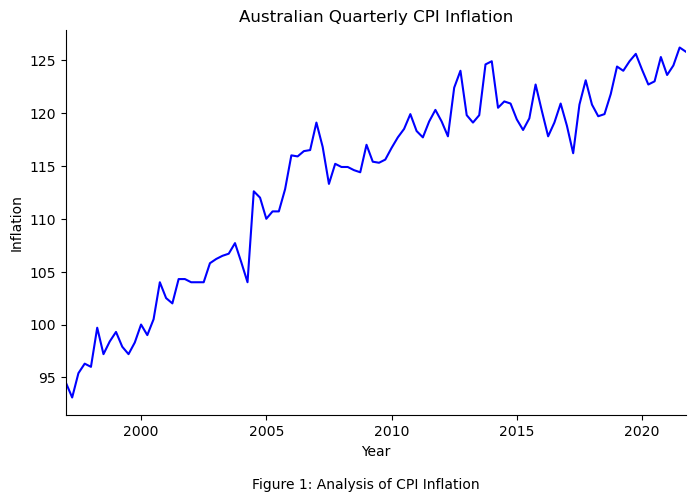

In [13]:
y = clean_CPI_train_data['CPI']

fig_CPI_initial, ax_CPI_intial = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_CPI_intial)
ax_CPI_intial.set_xlabel('Year')
ax_CPI_intial.set_ylabel('Inflation')
ax_CPI_intial.set_title('Australian Quarterly CPI Inflation')
ax_CPI_intial.set_xticks([], minor=True)
fig_CPI_initial.text(0.5, -0.03, "Figure 1: Analysis of CPI Inflation",
                     ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

**Figure 1** illustrates the long-term trend in Australian quarterly CPI inflation, showing a steady upward trajectory that reflects the gradual increase in consumer prices over time. This positive trend is indicative of inflation, as prices generally rise year after year. The plot also highlights periods of volatility, with noticeable fluctuations that suggest varying inflation rates in response to economic conditions. A notable dip around 2008 likely corresponds to a period of deflation, potentially driven by a significant reduction in automotive fuel prices, as noted by Treasury Ministers (2021). This figure captures both the inflationary pattern and the periodic economic influences affecting consumer prices.

## Seasonal Plots

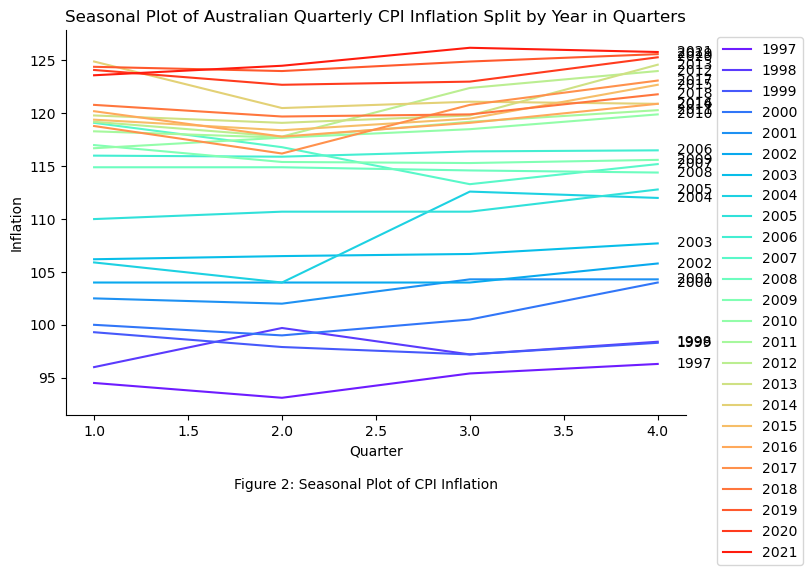

In [14]:
# Customize the colors for each year (example with a range of colors)
custom_palette = sns.color_palette("rainbow", len(
    clean_CPI_train_data.index.year.unique()))

fig_CPI_seasonal, ax_CPI_seasonal = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.quarter,
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonal
)

ax_CPI_seasonal.set_xlabel('Quarter')
ax_CPI_seasonal.set_ylabel('Inflation')
ax_CPI_seasonal.set_title('Seasonal Plot of Australian Quarterly CPI Inflation Split by Year in Quarters')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonal.text(
        # Position slightly to the right of the last point
        x=year_data.index.quarter.max() + 0.1,
        y=year_data['CPI'].iloc[-1],           
        s=str(year),                            
        verticalalignment='center'
    )

fig_CPI_seasonal.text(0.5, -0.03, "Figure 2: Seasonal Plot of CPI Inflation",
                        ha='center', va='center', fontsize=10)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

The seasonal plot of Australian quarterly CPI inflation from 1997 to 2021 shows a clear upward trend, reflecting long-term inflation as seen in **Figure 2**. Each group of years generally shifts higher, though certain periods, like 2006, show CPI values exceeding subsequent years (2007-2009), indicating occasional fluctuations in inflationary pressure. The plot clearly shows distinct groupings: 1997-1998 with a moderate rise, 2000-2003 with a more significant increase, and 2010-2021 showing a sustained upward shift, marking higher inflation over the last decade. Seasonally, **Quarter 2** and **Quarter 3** often show spikes, possibly due to seasonal economic factors in Australia, while **Quarter 4** frequently stabilises. This plot highlights both the gradual inflationary trend and the seasonal fluctuations within each year.

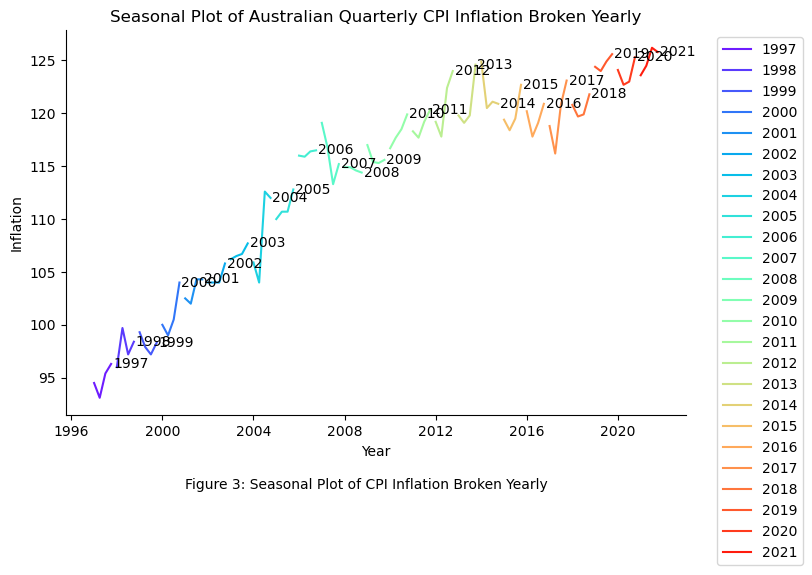

In [15]:
fig_CPI_seasonality_month_broken_yearly, ax_CPI_seasonality_broken_yearly = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.to_timestamp(),
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonality_broken_yearly
)

ax_CPI_seasonality_broken_yearly.set_xlabel('Year')
ax_CPI_seasonality_broken_yearly.set_ylabel('Inflation')
ax_CPI_seasonality_broken_yearly.set_title(
    'Seasonal Plot of Australian Quarterly CPI Inflation Broken Yearly')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonality_broken_yearly.text(
        # Position slightly to the right of the last point
        x=year_data.index.to_timestamp().max() + pd.DateOffset(months=1),
        y=year_data['CPI'].iloc[-1],           
        s=str(year),                            
        verticalalignment='center'
    )

fig_CPI_seasonality_month_broken_yearly.text(0.5, -0.03, "Figure 3: Seasonal Plot of CPI Inflation Broken Yearly",
                                                ha='center', va='center', fontsize=10)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

**Figure 3** provides a breakdown of yearly CPI inflation trends from 1997 to 2021, showing how each year contributes to the overall rise in consumer prices. This plot captures individual annual patterns, revealing that while there is a steady upward trend in CPI over time, the rate of inflation varies across years. Certain periods, such as 2000-2003 and 2010-2013, experience sharper increases, while others, like 2006-2008, show deflation in consumer prices. By isolating yearly trajectories, this visualisation highlights the non-uniform nature of inflation over time, aligning with the cumulative inflation patterns observed in the broader CPI dataset.

## ACF and PACF Plots

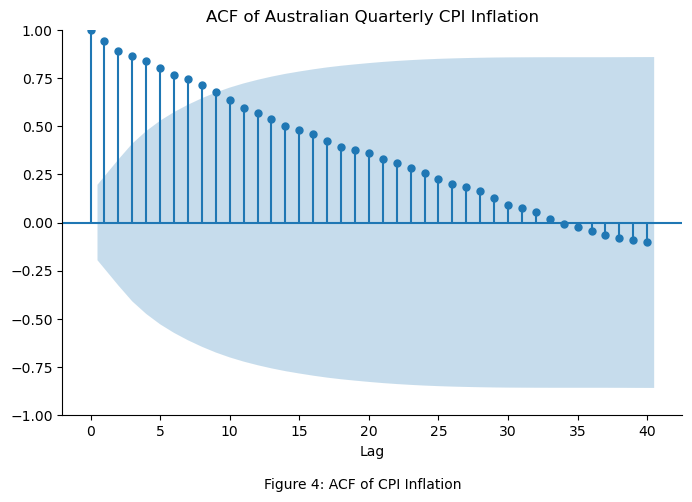

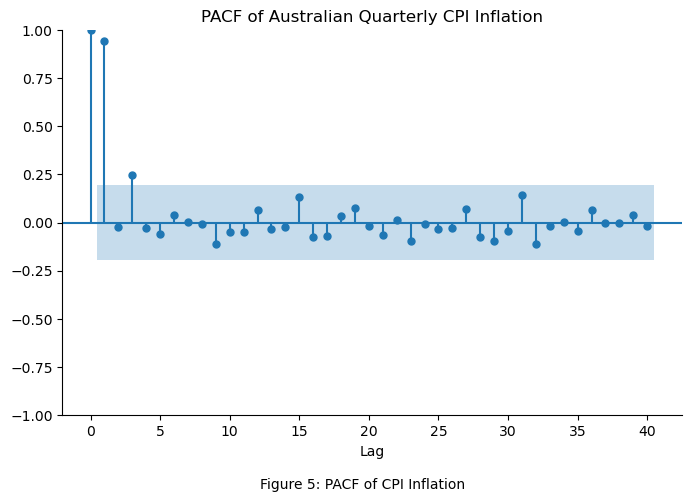

In [16]:
# ACF plots of the CPI data for 40 lags
fig_CPI_acf, ax_CPI_acf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax_CPI_acf, alpha=0.05)
ax_CPI_acf.set_xlabel('Lag')
ax_CPI_acf.set_title('ACF of Australian Quarterly CPI Inflation')
fig_CPI_acf.text(0.5, -0.03, "Figure 4: ACF of CPI Inflation",
                    ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

# PACF plots of the CPI data for 40 lags
fig_CPI_pacf, ax_CPI_pacf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax_CPI_pacf, alpha=0.05)
ax_CPI_pacf.set_xlabel('Lag')
ax_CPI_pacf.set_title('PACF of Australian Quarterly CPI Inflation')
fig_CPI_pacf.text(0.5, -0.03, "Figure 5: PACF of CPI Inflation",
                    ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

The autocorrelation function (ACF) (**Figure 4**) and partial autocorrelation function (PACF) (**Figure 5**) plots for Australian quarterly CPI inflation reveal a strong autoregressive structure, with the ACF showing significant autocorrelation that slowly decays over several lags, suggesting a non-stationary time series with a trend. The rapid drop in the PACF after lag 1 implies a low-order autoregressive process, likely AR(1). These patterns indicate that the CPI inflation series may benefit from an **ARIMA(1,1,0)** model, where differencing $d=1$ addresses non-stationarity. Given the quarterly frequency of the data, exploring seasonal patterns with a SARIMA model can provide deeper insights, as economic indicators like CPI often exhibit seasonal behavior. 

# Model Development

## Time Series Decomposition

In order to pick which models are suitable for the CPI dataset, applying time series decomposition is essential in the model development stage since it enhances the understanding of data patterns by breaking the series into trend, seasonality, and residual components.  This makes it easier to identify patterns and in turn make improvements to forecasting accuracy.  Furthermore, it helps achieve stationarity, which is crucial for models such as SARIMA. and enhances interpretability by isolating each components effect.  This logical approach helps create a more accurate, insightful forecasting models.

In [17]:
window_size = 12    
decomposition = seasonal_decompose(y, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

The use of `seasonal_decompose` from `statsmodels` is a way to decompose the time series data to gain insights into its underlying trend, seasonal variations, and residual noise, which are essential for understanding patterns and making future predictions. We apply a simple moving average filter with `filt=np.repeat(1/window_size, window_size)`, where `window_size = 12`. This filter averages values within the specified window, with each weight set to $\frac{1}{window\_size}$.  Since the data is quarterly, we set `period=4` to capture seasonal patterns that repeat every four quarters.

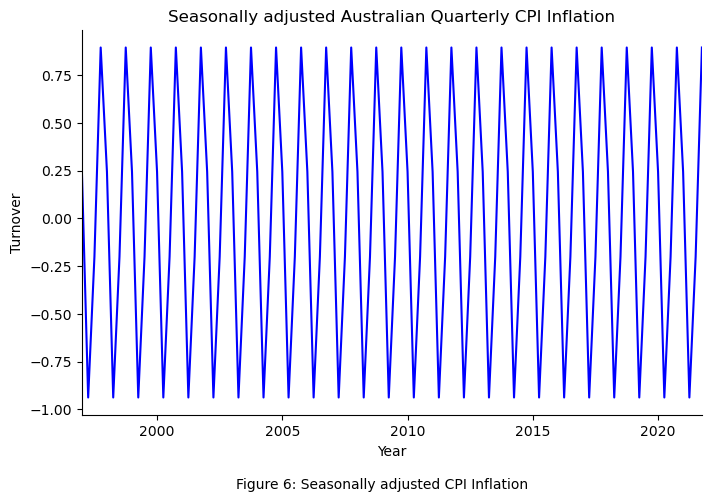

In [18]:
fig_seasonal_decomposition, ax_seasonal_decomposition = plt.subplots(
    figsize=(8, 5))
decomposition.seasonal.plot(color='blue', ax=ax_seasonal_decomposition)
ax_seasonal_decomposition.set_xlabel('Year')
ax_seasonal_decomposition.set_ylabel('Turnover')
ax_seasonal_decomposition.set_title(
    'Seasonally adjusted Australian Quarterly CPI Inflation')
ax_seasonal_decomposition.set_xticks([], minor=True)
fig_seasonal_decomposition.text(0.5, -0.03, "Figure 6: Seasonally adjusted CPI Inflation",
                                ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

The seasonality plot for Australian quarterly CPI inflation which is seen in **Figure 6** reveals a strong, stable cyclical pattern with consistent range and a four quarter periodicity, showing a reliable annual seasonality in inflation. This stable pattern suggests that recurring factors influence inflation similarly each year, unaffected by external factors. The predictable seasonality is advantageous for forecasting, as seasonal models such as SARIMA can leverage this regularity for improved accuracy. The periodic nature may also reflect underlying economic cycles tied to consumer or production behaviors, making this insight valuable for both forecasting and understanding inflation drivers.

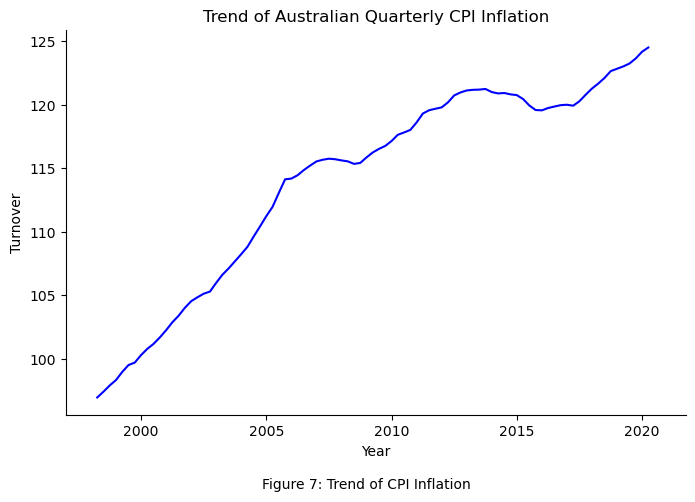

In [19]:
fig_trend_decomposition, ax_trend_decomposition = plt.subplots(figsize=(8, 5))
decomposition.trend.plot(color="blue", ax=ax_trend_decomposition)
ax_trend_decomposition.set_xlabel('Year')
ax_trend_decomposition.set_ylabel('Turnover')
ax_trend_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_trend_decomposition.set_xticks([], minor=True)
fig_trend_decomposition.text(0.5, -0.03, "Figure 7: Trend of CPI Inflation",
                             ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

The trend plot of Australian quarterly CPI inflation from the time series decomposition which is seen in **Figure 7** shows a steady upward trajectory, indicating a long-term increase in consumer prices. This reflects sustained inflation, with times when it speeds up and other times when it slows down. For instance, there is rapid growth between 2000 and 2008, likely reflecting a period of economic expansion, followed by a plateau around 2015, which might align with low-inflation policies or economic stabilisation. The recent rise post-2015 suggests a renewed inflationary trend, potentially due to economic factors like policy shifts or global influences on the economy. This trend highlights the persistent rise in the cost of living over time, making it important for policymakers to observe the inflation and manage it to keep the economy more stable. 

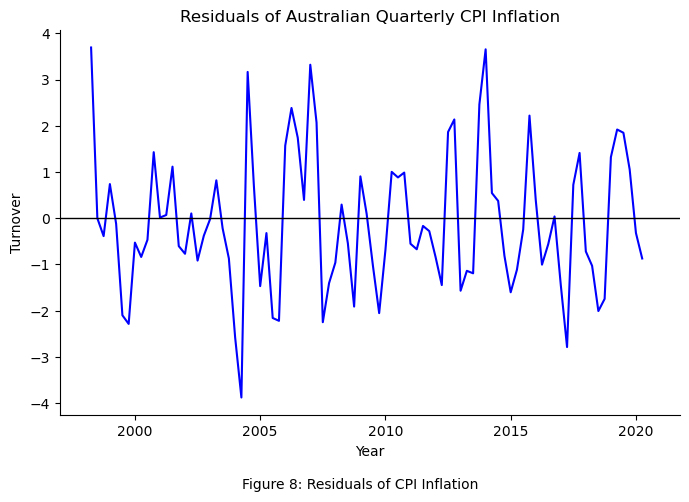

In [20]:
fig_resid_decomposition, ax_resid_decomposition = plt.subplots(figsize=(8, 5))
decomposition.resid.plot(color='blue', ax=ax_resid_decomposition)
ax_resid_decomposition.axhline(0, color='black', lw=1)
ax_resid_decomposition.set_xlabel('Year')
ax_resid_decomposition.set_ylabel('Turnover')
ax_resid_decomposition.set_title('Residuals of Australian Quarterly CPI Inflation')
ax_resid_decomposition.set_xticks([], minor=True)
fig_resid_decomposition.text(0.5, -0.03, "Figure 8: Residuals of CPI Inflation",
                             ha='center', va='center', fontsize=10)
sns.despine()
plt.show()

The residual plot for Australian quarterly CPI inflation which is seen in **Figure 8** shows random fluctuations around zero, indicating that the time series decomposition effectively removed trend and seasonal components, leaving only noise. Occasional large deviations, such as in the early 2000s and around 2008, likely caused by sudden economic events or policy decisions that are not captured by trend or seasonality. Since there are no clear residual patterns, it suggests that the model is a good fit and further forecasts based on the trend and seasonal parts should be reliable as there is no predictability left in the residuals.

By analysing the trend, seasonality, and residuals during the time series decomposition phase, we can identify potential models for achieving the most accurate CPI forecast. We will implement smoothing models such as Simple Exponential, Holt Exponential, and Holt-Winters Exponential in various forms, along with SARIMA models. Given the clear presence of seasonality, first-order differencing will be applied to enable SARIMA modeling.

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

**Formula:** 

\begin{align*}
\boldsymbol{\Delta} y_t = \boldsymbol{\alpha} + \boldsymbol{\beta} t + \boldsymbol{\gamma} y_{t-1} + \boldsymbol{\delta}_1 \boldsymbol{\Delta} y_{t-1} \dots + \boldsymbol{\delta}_{p-1} \boldsymbol{\Delta} y_{t-p+1} + \boldsymbol{\epsilon}_t,
\end{align*}


where $\boldsymbol{\alpha}$ is a constant term,  $\boldsymbol{\beta} t$ is the trend coefficient, $\boldsymbol{\gamma} y_{t-1}$ is the coefficient of the lagged level of time series, $\boldsymbol{\delta}_i$ are the coefficients of the lagged differences, $t$ is the time index, $p$ is the number of lags, and $\boldsymbol{\epsilon}_t$ is the error term  

$\boldsymbol{H_0}:$ The time series is non-stationary.


$\boldsymbol{H_A}:$ The time series is stationary.


**Threshold:**


$\boldsymbol{\alpha} = 0.05$

In [21]:
def test_stationarity(timeseries):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    if dftest[0] < dftest[4]["5%"]:
        print('Reject H0 - Time Series is stationary')
    else:
        print('Failed to reject H0 - Time series is non-stationary')


test_stationarity(y)

Results of Dickey-Fuller Test:
Test Statistic                 -2.133199
p-value                         0.231376
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64
Failed to reject H0 - Time series is non-stationary


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  This further supports the use of smoothing models and SARIMA models to forecast the future predictions of the Australian CPI Inflation.

## SARIMA Model

The SARIMA model is ideal for forecasting CPI data because it captures seasonal patterns, trends, and short-term dependencies commonly found in economic series. Unlike standard ARIMA, which addresses only trends and short-term dependencies, SARIMA includes seasonal components that enable it to effectively handle regular seasonal fluctuations. By incorporating both regular and seasonal differencing, SARIMA ensures stationarity, which is a key factor for reliable predictions. Its flexibility in managing autoregressive and moving average components for seasonal cycles allows it to account for recurring patterns and underlying inflation dynamics, making it especially valuable for accurate, long-term CPI forecasts essential for economic planning and decision-making.

In [22]:
sarima_model_aic = pm.auto_arima(y, seasonal=True, m=4,
                             information_criterion='aic', test='adf',
                             suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=396.102, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=422.341, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=420.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=414.261, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=422.781, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=394.706, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=396.295, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=396.048, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=394.186, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=395.309, Time=0.52 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=397.790, Time=0.85 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=394.774, Time=0.15 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=394.663, Time=0.14 sec
 ARIMA(3,1,2)(1,0,0)[4] intercept   : AIC=398.695, Time=0.15 sec
 ARIMA(2,1,3)(1,0,0)[4] intercept   : AIC=398.6

Using the `auto_arima` function is a way to automate the process of selecting an optimal model configuration without manually testing different combinations.

`auto_arima` is configured with `seasonal=True` with period of `m=4` which is useful for CPI dataset since it is represented in quarters.  The `information_criterion='aic'` is used to evaluate models based on the AIC, aiming to minimise this value for the best model fit.  Furthermore, `test='adf'` is used for the function to perform the Augmented Dickey-Fuller (ADF) test to determine the differencing order needed to make the series stationary.  This test was also used since ADF was used in the Testing for Stationary Points section of the notebook to keep it uniform.

For presentation purposes, `suppress_warnings=True` is used to keep the output cleaner by hiding warning messages, while `trace=True` provides detailed output, showing each model tried along with its AIC score and the time taken to fit.

From the above, the function uses a stepwise search across different combinations of the SARIMA parameters: $(p, d, q)$ for non ARIMA component and $(P, D, Q, m)$ for the seasonal component.  Each line of the output shows the different configurations with its corresponding AIC score.  By comparing each one, the function identified that the best SARIMA model is **ARIMA(2, 1, 2)(1, 0, 0)[4] with intercept**, which has an AIC score of **394.186**.

In [23]:
sarima_model_aic.set_params()

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 0, 4),
      suppress_warnings=True)

In [24]:
sarima_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Wed, 06 Nov 2024   AIC                            394.186
Time:                                    00:06:52   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The `SARIMAX(2, 1, 2)×(1, 0, [], 4)` model fits the quarterly data well, with an AIC of **394.186** and BIC of **412.351**, indicating a good balance between fit quality and complexity. Significant coefficients for the intercept, AR(2), and seasonal AR terms highlight their relevance in capturing data patterns, while insignificant AR(1) and MA terms suggest limited impact.

In [25]:
sarima_model_bic = pm.auto_arima(y, seasonal=True, m=4,
                                 information_criterion='bic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : BIC=416.863, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=427.532, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=431.360, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=424.642, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=425.376, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : BIC=412.871, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : BIC=411.865, Time=0.05 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : BIC=412.351, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : BIC=408.676, Time=0.05 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : BIC=410.345, Time=0.05 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : BIC=411.292, Time=0.04 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : BIC=411.266, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : BIC=407.290, Time=0.03 sec
 ARIMA(0,1,2)(1,0,0)[4] intercept   : BIC=410.796, Time=0.06 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : BIC=411.1

Majority of the configuration are mentioned in the development of the SARIMA model using AIC but in this case, we make the following changes to account for BIC instead: `information_criterion='bic'`.

From the above, the function identified that the best SARIMA model is **ARIMA(0, 1, 3)(0, 0, 0)[4] with intercept**, which has a BIC score of **406.951**.


In [26]:
sarima_model_bic.set_params()

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

In [27]:
sarima_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -191.988
Date:                Wed, 06 Nov 2024   AIC                            393.976
Time:                        00:06:54   BIC                            406.951
Sample:                    03-31-1997   HQIC                           399.226
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3181      0.098      3.248      0.001       0.126       0.510
ma.L1         -0.2113      0.110     -1.921      0.055      -0.427       0.004
ma.L2         -0.5300      0.080     -6.594      0.000      -0.688      -0.372
ma.L3          0.2455      0.109      2.255      0.024       0.032       0.459
sigma2         2.8079      0.418      6.722      0.000       1.989       3.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


The `SARIMAX(0, 1, 3)` model fits the quarterly data well, with an AIC of **393.976** and a BIC of **406.951**, which suggests an optimal balance between model fit and complexity.  Significant coefficients for the intercept, MA(2) and MA(3) terms highlight their importance in capturing data patterns, while the insignificant MA(1) term suggests a limited impact.

In [28]:
sarima_aic_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)
sarima_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Wed, 06 Nov 2024   AIC                            394.186
Time:                                    00:06:54   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Diagnosis

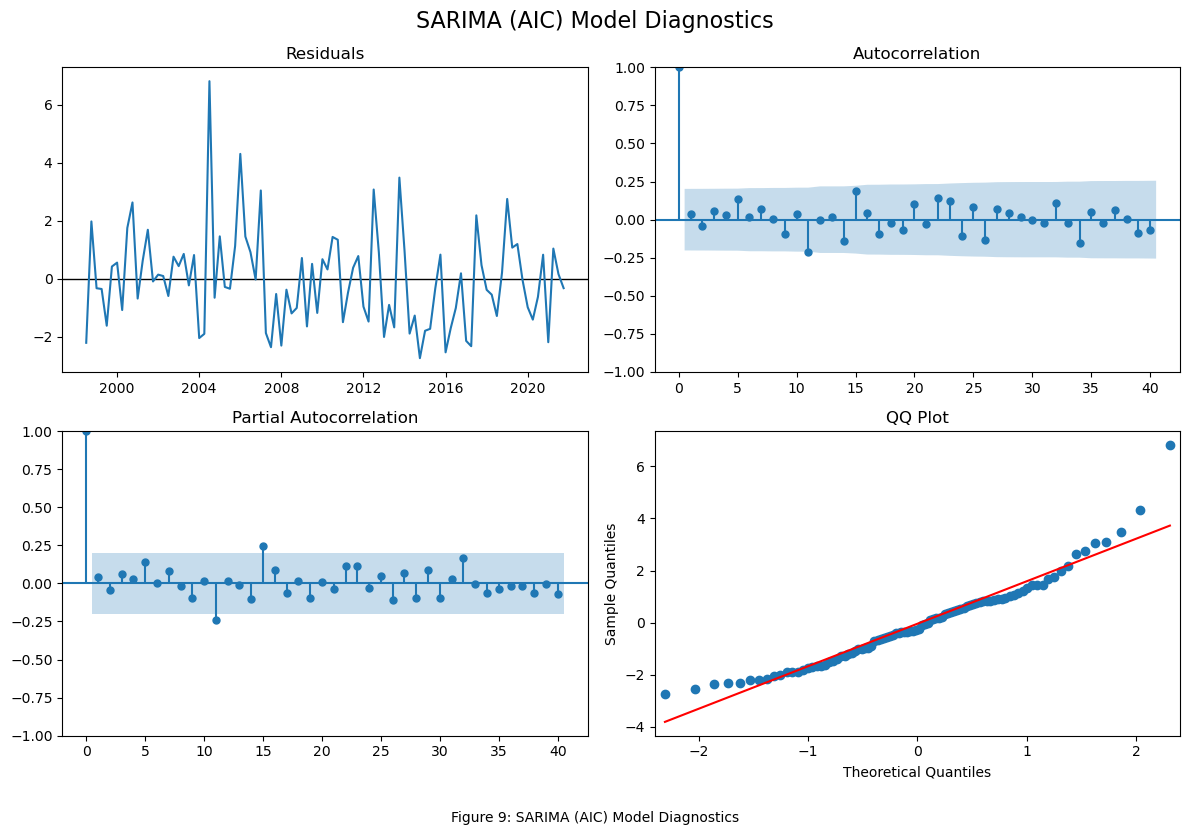

In [29]:
sarima_aic_resid = sarima_aic_model.resid()

if isinstance(sarima_aic_resid.index, pd.PeriodIndex):
    sarima_aic_resid.index = sarima_aic_resid.index.to_timestamp()

resid_no_initial_aic = sarima_aic_resid[6:]

# Plot residuals manually
fig_sarima_aic, ax_sarima_aic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_aic.suptitle("SARIMA (AIC) Model Diagnostics", fontsize=16)
ax_sarima_aic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_aic[0, 0].plot(resid_no_initial_aic)
ax_sarima_aic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_aic, ax=ax_sarima_aic[0, 1], alpha=0.05, lags=40)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_aic, ax=ax_sarima_aic[1, 0], alpha=0.05, lags=40)

# QQ plot
sm.qqplot(resid_no_initial_aic, line='s', ax=ax_sarima_aic[1, 1])
ax_sarima_aic[1, 1].set_title("QQ Plot")

fig_sarima_aic.text(0.5, -0.03, "Figure 9: SARIMA (AIC) Model Diagnostics",
                    ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

The diagnostic plots for the SARIMA (AIC) model in **Figure 9** shows that, the overall model fits well with the data, however, there are some minor areas for improvement. 

The residuals fluctuate around zero, showing stationarity, which suggests that the model has captured the main structure of the time series which is necessary for SARIMA model. However, certain periods, notably around 2004-2005, indicates significant residual spikes, hinting that some aspects of the data, such as outliers and seasonal effects may not be fully captured by the model.

In the ACF plot, we observe that almost all lag values fall within the 95% confidence interval, which suggests that the residuals do not show significant autocorrelation. The lack of spikes outside the confidence bounds indicates that the residuals resemble white noise, implying that the SARIMA model has successfully captured the successive correlation structure in the data.

Similarly, the PACF plot supports this, as most spikes are within the 95% confidence interval. This pattern shows that the SARIMA model has successfully captured the relationships in the data, since there are no strong partial correlations that would suggest any remaining patterns in the residuals 

The QQ plot shows that the residuals are approximately normally distributed, as most points lie along the reference line. There are minor deviations at the left tail, however, there is a major outlier on the right tail.  From this, it indicates that there is presence of right skewness since there is heavier tails on the positive side.

Overall, the SARIMA (AIC) model appears robust, as clearly shown by the residuals’ lack of strong autocorrelation and is close to normal. The minor issues, such as occasional residual spikes and small autocorrelation at the early lags, shows room for improvement. In saying that, the model is adequate for forecasting the future CPI inflation, though further adjustments could enhance its performance, particularly if more precision is required.

In [30]:
sarima_bic_model = pm.ARIMA(order=(0, 1, 3), seasonal_order=(0, 0, 0, 4), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)
sarima_bic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -191.988
Date:                Wed, 06 Nov 2024   AIC                            393.976
Time:                        00:06:54   BIC                            406.951
Sample:                    03-31-1997   HQIC                           399.226
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3181      0.098      3.248      0.001       0.126       0.510
ma.L1         -0.2113      0.110     -1.921      0.055      -0.427       0.004
ma.L2         -0.5300      0.080     -6.594      0.000      -0.688      -0.372
ma.L3          0.2455      0.109      2.255      0.024       0.032       0.459
sigma2         2.8078      0.418      6.722      0.000       1.989       3.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Diagnosis

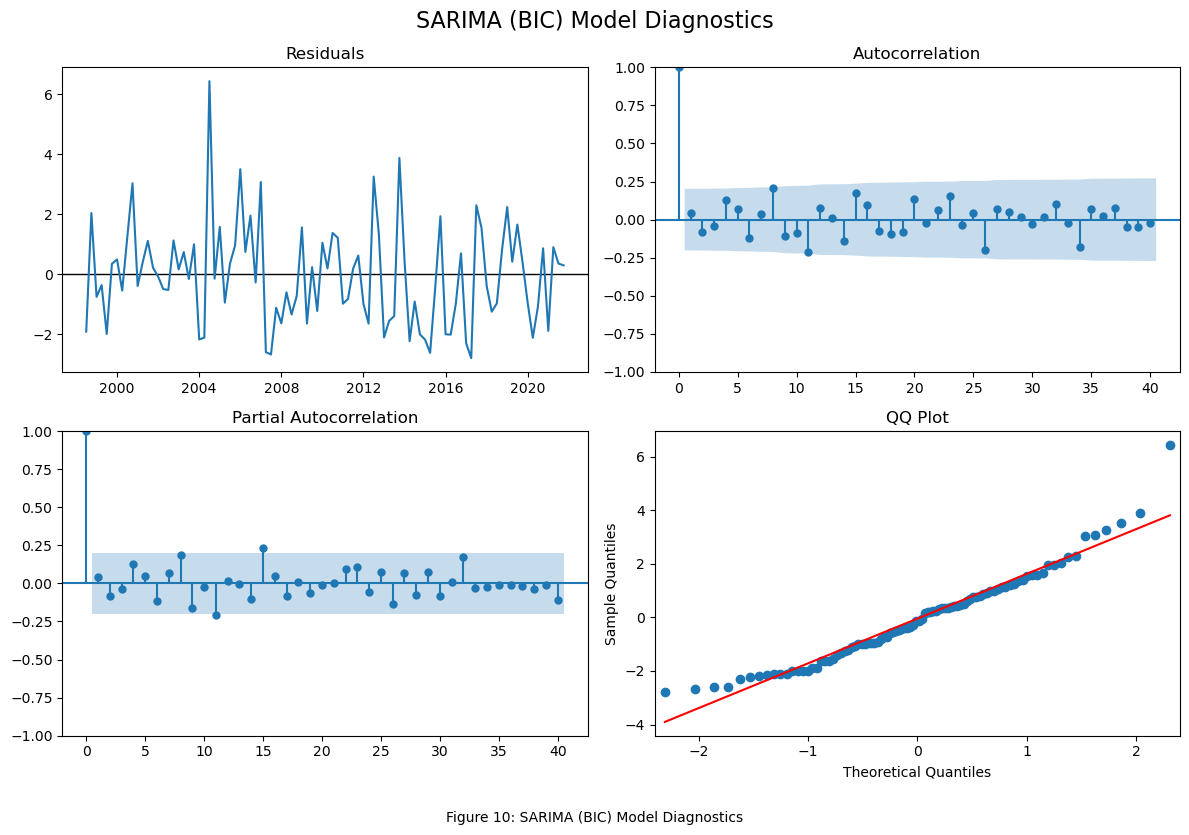

In [31]:
sarima_bic_resid = sarima_bic_model.resid()

if isinstance(sarima_bic_resid.index, pd.PeriodIndex):
    sarima_bic_resid.index = sarima_bic_resid.index.to_timestamp()

resid_no_initial_bic = sarima_bic_resid[6:]

# Plot residuals manually
fig_sarima_bic, ax_sarima_bic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_bic.suptitle("SARIMA (BIC) Model Diagnostics", fontsize=16)
ax_sarima_bic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_bic[0, 0].plot(resid_no_initial_bic)
ax_sarima_bic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_bic, ax=ax_sarima_bic[0, 1], alpha=0.05, lags=40)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_bic, ax=ax_sarima_bic[1, 0], alpha=0.05, lags=40)

# QQ plot
sm.qqplot(resid_no_initial_bic, line='s', ax=ax_sarima_bic[1, 1])
ax_sarima_bic[1, 1].set_title("QQ Plot")

fig_sarima_bic.text(0.5, -0.03, "Figure 10: SARIMA (BIC) Model Diagnostics",
                    ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

The diagnostic plots for the SARIMA (BIC) model in **Figure 10** shows that this model is reasonably well fitted to the data, almost similar as the AIC model which have some areas that can be improved on

In terms of the residual plot, the residuals fluctuate around zero, showing that the model captures the main structure of the time series. However, there are some spikes, particularly around 2004-2005, suggesting potential outliers or pattern in the data that the model hasn’t fully accounted for. Generally, the residuals appear stationary, which supports the assumption of a well-fitted SARIMA model.

In the ACF plot, we observe that almost all lags fall within the 95% confidence interval, indicating that there is minimal autocorrelation in the residuals. This suggests that the SARIMA model has adequately captured the serial dependencies in the data, as significant autocorrelation would have shown numerous spikes outside the confidence interval.

Similarly, the PACF plot supports this, as most spikes are within the bounds. This further supports that the SARIMA model has explained the relationships in the data, as there are no strong partial correlations showing in the remaining patterns.

The QQ plot shows that the residuals approximate to a normal distribution well, with most points aligning closely with the reference line. There are minor deviations at the left tail, however, there is a major outlier on the right tail.  From this, it indicates that there is presence of right skewness since there is heavier tails on the positive side.

In conclusion, the SARIMA (BIC) model generally performs well, as seen by mostly uncorrelated and approximately normally distributed residuals. Small improvements might be made to address occasional spikes in the residuals and small residual autocorrelations at early lags. In saying that, the model is likely robust for forecasting the future CPI inflation, with room of improvement to achieve optimal accuracy.

#### Plotting Smoothing Model Forecasts

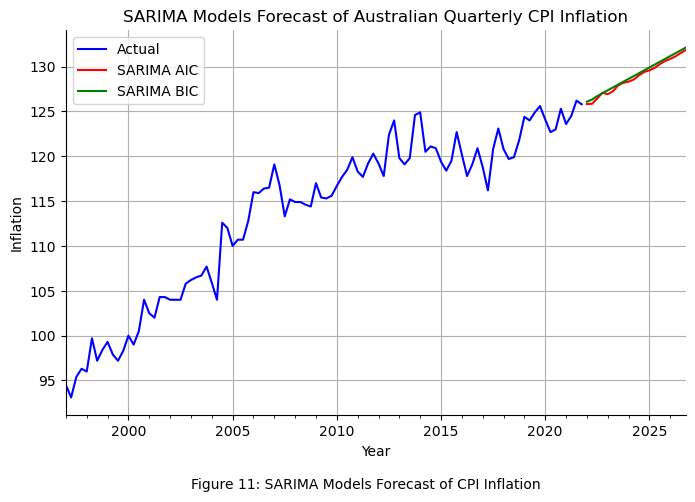

In [49]:
# Plot the forecast of the SARIMA model
fig_sarima_forecast, ax_sarima_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_sarima_forecast)
sarima_aic_model.predict(20).plot(color='r', ax=ax_sarima_forecast)
sarima_bic_model.predict(20).plot(color='g', ax=ax_sarima_forecast)
ax_sarima_forecast.set_xlabel('Year')
ax_sarima_forecast.set_ylabel('Inflation')
ax_sarima_forecast.set_title('SARIMA Models Forecast of Australian Quarterly CPI Inflation')
fig_sarima_forecast.text(0.5, -0.03, "Figure 11: SARIMA Models Forecast of CPI Inflation",
                         ha='center', va='center', fontsize=10)
sns.despine()
plt.legend(loc='best', labels=['Actual', 'SARIMA AIC', 'SARIMA BIC'])
plt.grid()
plt.show()

The forecast graph for Australian Quarterly CPI Inflation in **Figure 11** shows actual data with predictions from two SARIMA models optimised by AIC (red) and BIC (green). Both models closely follow the actual data, capturing the inflation trend and seasonal patterns. The BIC model takes a slightly more traditional approach, with a smoother forecast line due to BIC’s higher penalty for complexity, potentially reducing overfitting. The forecasts extends 5 years into the future, showing a steady upward trend that aligns with historical data, though SARIMA models generally don’t account for unexpected economic shifts. 

For practical use, the BIC model may suit policymakers needing stable and cautious forecasts, while the AIC model, being more responsive, could be better for short-term precision. Both models suggest continued CPI growth, implying a need for inflation control if the trend persists. Their similar trajectories over the forecast period increase confidence in their accuracy for the medium-term.  The choice between the two models depends on whether stability or quick response to changes is important.

## Smoothing Models

Smoothing models like Simple Exponential Smoothing (SES), Holt Exponential Smoothing, and Holt-Winters Exponential Smoothing are ideal for CPI data as they capture inflation patterns through varying levels of trend and seasonality. Simple Exponential Smoothing suits stable CPI data, while Holt’s method accounts for trends, and Holt-Winters handles both trends and seasonality which is important for seasonal CPI fluctuations. These models are responsive to recent data, adapting quickly to economic shifts, and are easier to interpret than complex models such as SARIMA, making them well-suited for presenting CPI forecasts to stakeholders who need clear insights into inflation trends.

### Simple Exponential Smoothing 

SES is useful for forecasting stable time series data like quarterly CPI by smoothing random fluctuations and emphasising recent data, making it ideal when there’s no trend or seasonality. It serves as a benchmark to assess the effectiveness of more complex models like Holt's, Holt-Winters, and SARIMA, helping determine if their added complexity provides significant accuracy improvements over SES for short-term forecasting.

In [33]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(optimized=True)
fitted_simple_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


### Holt Exponential Smoothing

Holt's Exponential Smoothing is a much more effective method for forecasting CPI data when a trend is present, as it incorporates both the level and trend components of the time series. Unlike SES, which assumes a constant level, Holt’s method can capture regular increases or decreases, making it a suitable model for CPI data that reflects inflationary or deflationary trends over time. By emphasising recent observations and adapting to gradual changes in trend, it produces forecasts that account for both short term fluctuations and long term patterns. This approach allows for a more responsive and accurate model compared to SES, which makes Holt's method a middle ground model between simpler models like SES and more complex options like Holt-Winters and SARIMA, particularly when dealing with economic data that evolves gradually.

In [34]:
holt_exponential_smoothing = Holt(y, initialization_method="estimated")
fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(optimized=True)
fitted_holt_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,Holt,SSE,357.486
Optimized:,True,AIC,135.393
Trend:,Additive,BIC,145.813
Seasonal:,None,AICC,136.296
Seasonal Periods:,None,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4700246,alpha,True
smoothing_trend,0.000000,beta,True


#### Plotting Smoothing Model Forecasts

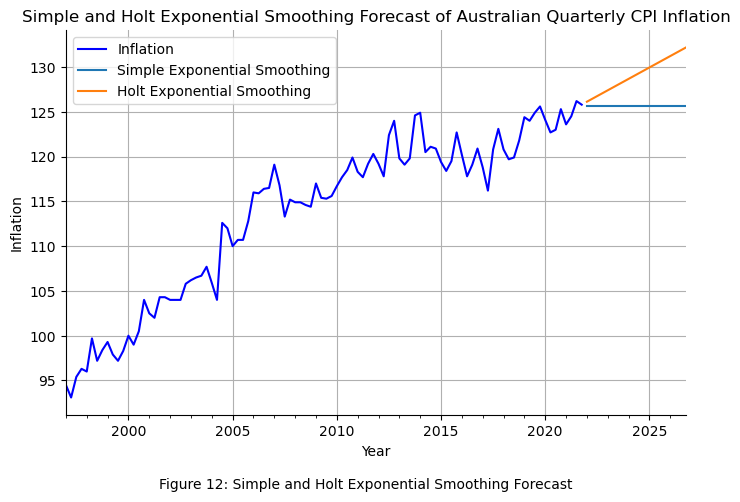

In [50]:
horizon = 20

smoothing_models = [fitted_simple_exponential_smoothing,
                    fitted_holt_exponential_smoothing]
model_names = ['Simple Exponential Smoothing',
               'Holt Exponential Smoothing']

fig_forecast, ax_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')

for model, name in zip(smoothing_models, model_names):
    pred = model.forecast(horizon)
    pred.plot(ax=ax_forecast, label=name)

ax_forecast.set_xlabel('Year')
ax_forecast.set_ylabel('Inflation')
ax_forecast.set_title(
    'Simple and Holt Exponential Smoothing Forecast of Australian Quarterly CPI Inflation')
fig_forecast.text(0.5, -0.03, "Figure 12: Simple and Holt Exponential Smoothing Forecast",
                  ha='center', va='center', fontsize=10)
plt.legend(loc='best')
plt.grid()
sns.despine()
plt.show()

The forecast graph in **Figure 12** compares SES and Holt Exponential Smoothing for Australian CPI inflation. SES, shown in light blue, produces a flat forecast which is expected, as it doesn’t account for trends, making it unsuitable for the data as it shows a clear upward trend. In contrast, Holt’s model, shown in orange, incorporates a trend component, allowing it to capture the general upward movement in CPI and provide a more reliable projection of inflation growth. However, Holt’s linear forecast may miss finer seasonal variations or shifts in the trend. 

Overall, Holt Exponential Smoothing offers a better fit for this data, highlighting the importance of choosing a model that matches the data’s trend characteristics.

### Holt-Winters Exponential Smoothing

Holt-Winters Exponential Smoothing variations are ideal for forecasting CPI data that displays both trend and seasonal patterns, as they use multiple components to adapt to specific characteristics of the data. 

The Seasonal Additive variation is effective when CPI seasonal fluctuations remain relatively stable over time, adding a seasonal component to capture recurring quarterly inflation changes. 

In contrast, the Seasonal Multiplicative variation is better suited for CPI data where seasonal effects scale with the overall level, which is common in economic data affected by inflation. The Seasonal Multiplicative with Damped Trend model is beneficial when the CPI trend is expected to gradually stabilise, as it allows for a weakening trend over time, useful for long-term forecasts where growth may slow. 

Lastly, the Logged Seasonal Additive variation is helpful when CPI data exhibits multiplicative seasonal patterns with increasing volatility at higher levels.  Hence, logging the data stabilises variance, while the additive seasonal component captures consistent seasonal behavior. 

Together, these Holt-Winters variations will provide a flexible modeling framework for capturing both trend and seasonality in CPI data, allowing for more accurate and reliable forecasting than simpler models such as SES.

In [36]:
ahw=ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,291.201
Optimized:,True,AIC,122.884
Trend:,Additive,BIC,143.726
Seasonal:,Additive,AICC,125.356
Seasonal Periods:,4,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5691148,alpha,True
smoothing_trend,4.7635e-10,beta,True


In [37]:
mhw = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                           seasonal="mul", initialization_method="estimated").fit()
mhw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,276.717
Optimized:,True,AIC,133.782
Trend:,Additive,BIC,175.465
Seasonal:,Multiplicative,AICC,142.227
Seasonal Periods:,12,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5404220,alpha,True
smoothing_trend,0.000000,beta,True


In [38]:
mhw_damped = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                                  seasonal="mul", damped_trend=True, initialization_method="estimated").fit()
mhw_damped.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,269.035
Optimized:,True,AIC,132.967
Trend:,Additive,BIC,177.255
Seasonal:,Multiplicative,AICC,142.467
Seasonal Periods:,12,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4759881,alpha,True
smoothing_trend,2.1008e-12,beta,True


In [39]:
ahw_log = ExponentialSmoothing(np.log(y), seasonal_periods=12, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw_log.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,0.022
Optimized:,True,AIC,-810.909
Trend:,Additive,BIC,-769.226
Seasonal:,Additive,AICC,-802.464
Seasonal Periods:,12,Date:,"Wed, 06 Nov 2024"
Box-Cox:,False,Time:,00:06:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5218593,alpha,True
smoothing_trend,0.0240859,beta,True


#### Plotting Smoothing Model Forecasts

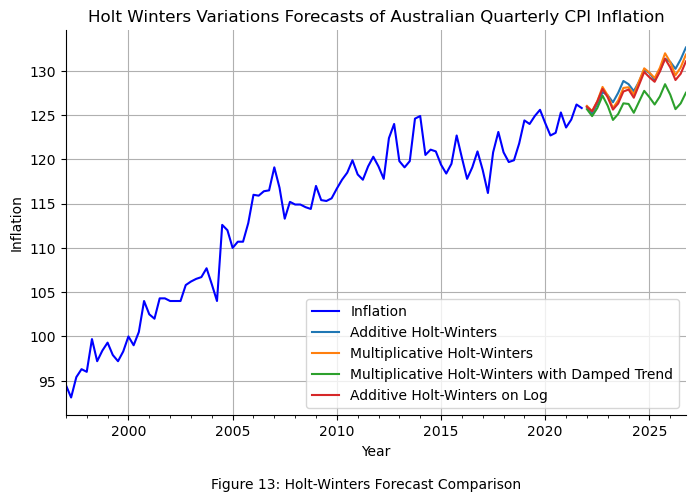

In [51]:
horizon = 20
holt_winters_models = [ahw, mhw, mhw_damped, ahw_log]
model_names = [
    'Additive Holt-Winters',
    'Multiplicative Holt-Winters',
    'Multiplicative Holt-Winters with Damped Trend',
    'Additive Holt-Winters on Log'
]

fig_comparison_hw, ax_comparison_hw = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
for i, model in enumerate(holt_winters_models):
    pred = model.forecast(horizon)

    if model_names[i] == 'Additive Holt-Winters on Log':
        pred = np.exp(pred)

    pred.plot(label=model_names[i])

ax_comparison_hw.set_xlabel('Year')
ax_comparison_hw.set_ylabel('Inflation')
ax_comparison_hw.set_title('Holt Winters Variations Forecasts of Australian Quarterly CPI Inflation')
fig_comparison_hw.text(0.5, -0.03, "Figure 13: Holt-Winters Forecast Comparison",
                       ha='center', va='center', fontsize=10)
plt.legend(loc='best')
plt.grid()
sns.despine()
plt.show()

This forecast graph for Australian Quarterly CPI Inflation in **Figure 13** shows several Holt-Winters models, each capturing trends and seasonality differently. The Additive Holt-Winters model (light blue) assumes a linear trend with constant seasonality, leading to a traditional forecast that may minimise the inflation’s growth. The Multiplicative Holt-Winters model (orange), which scales seasonal effects with data level, captures the trend and increasing seasonal magnitude effectively, making it well-suited for inflation forecasting. The Damped Trend version (green) modifies the trend over time, providing a more reliable outlook of the uncertainty of the future inflation growth. The Additive model on log-transformed data (red) stabilises fluctuations, resulting in a stable, smoothed forecast. Overall, the Multiplicative model is best for dynamic growth, while the Damped Trend and log-transformed variation offer more stable alternatives for cautious forecasting. 

# Model Validation

## Expanding Window Split

In [41]:
ts = np.log(y)  

validation = y['2017Q1':].index
start = y.index.get_loc('2017Q1')

seasonal_walk_pred = []
simple_exponential_smoothing_pred = []
holt_exponential_smoothing_pred = []
ahw_pred = []
mhw_pred = []
mhw_damped_pred = []
ahw_log_pred = []
sarima_aic_pred = []
sarima_bic_pred = []

for i in range(start, len(y)):

    seasonal_walk_pred.append(y.iloc[i-1])  # seasonal random walk forecast

    simple_exponential_smoothing_model = SimpleExpSmoothing(y.iloc[:i], initialization_method="estimated").fit()

    simple_exponential_smoothing_pred.append(simple_exponential_smoothing_model.forecast(1)[-1])  # simple exponential smoothing forecast

    holt_exponential_smoothing_model = Holt(y.iloc[:i], initialization_method="estimated").fit()

    holt_exponential_smoothing_pred.append(holt_exponential_smoothing_model.forecast(1)[-1])  # holt exponential smoothing forecast

    ahw_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="add", initialization_method="estimated").fit()
    
    ahw_pred.append(ahw_model.forecast(1)[-1])  # additive holt winters forecast

    mhw_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="mul", initialization_method="estimated").fit()
    
    mhw_pred.append(mhw_model.forecast(1)[-1])  # multiplicative holt winters forecast

    mhw_damped_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                            seasonal="mul", damped_trend=True, initialization_method="estimated").fit()
    
    mhw_damped_pred.append(mhw_damped_model.forecast(1)[-1])  # multiplicative holt winters forecast

    ahw_log_model = ExponentialSmoothing(ts.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="add", initialization_method="estimated").fit()
    
    resid = (ts.iloc[:i]-ahw_log_model.fittedvalues)[12:]  # residuals
    # forecast with a retransformation adjustment
    y_pred = np.exp(ahw_log_model.forecast(1)[-1])*np.mean(np.exp(resid))
    ahw_log_pred.append(y_pred)  # log additive holt winters forecast

    sarima_aic_model_ = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y.iloc[:i])
    
    sarima_aic_pred.append(sarima_aic_model_.predict(n_periods=1)[-1])

    sarima_bic_model_ = pm.ARIMA(order=(0, 1, 3), seasonal_order=(0, 0, 0, 4), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y.iloc[:i])
    
    sarima_bic_pred.append(sarima_bic_model_.predict(n_periods=1)[-1])

columns = ['Seasonal RW', 'Simple Exponential Smoothing', 'Holt Exponential Smoothing',
              'Additive Holt-Winters', 'Multiplicative Holt-Winters', 'Multiplicative Holt-Winters with Damped Trend',
                'Additive Holt-Winters on Log', 'SARIMA (AIC)', 'SARIMA (BIC)']
results = np.vstack([seasonal_walk_pred, simple_exponential_smoothing_pred, holt_exponential_smoothing_pred,
                     ahw_pred, mhw_pred, mhw_damped_pred, ahw_log_pred, sarima_aic_pred, sarima_bic_pred]).T

results = pd.DataFrame(results, columns=columns, index=validation)

For forecasting a CPI dataset, which often exhibits gradual trends and seasonal variations over time, the expanding window split is effective. By progressively adding more quarters of historical CPI data to the training set, this method allows the model to capture both short-term fluctuations and long-term inflationary trends. Fixed-window methods like TimeSeriesSplit or sliding window might miss these evolving patterns, especially if inflation dynamics shift due to economic events or policy changes. With expanding window, each new forecast benefits from an increasingly complete historical perspective, reducing the risk of data leakage and improving adaptability to changes in the CPI trend, making it well-suited for accurate inflation forecasting over time.

In [42]:
# Create a table to store the MSE values for each model
table = pd.DataFrame(0.0, index=results.columns, columns=['MSE'])

# Calculate RMSE for each model compared to the actual values
for i in range(len(results.columns)):
    table.iloc[i, 0] = mean_squared_error(y['2017Q1':], results.iloc[:, i])

# Round the RMSE values to two decimal places
table = table.round(3)

# Sort the table by best MSE value

table.sort_values(by='MSE', inplace=True)

table

,MSE
SARIMA (AIC),2.045
SARIMA (BIC),2.317
Multiplicative Holt-Winters,2.431
Additive Holt-Winters,2.432
Additive Holt-Winters on Log,2.460
Multiplicative Holt-Winters with Damped Trend,2.541
Holt Exponential Smoothing,3.420
Simple Exponential Smoothing,3.595
Seasonal RW,3.616


In forecasting the Consumer Price Index (CPI) dataset, SARIMA performs well with Expanding Window Split because it effectively captures seasonal and trend components that evolve over time. This method continuously adds new data to each forecast, allowing SARIMA to refine its parameters and stay aligned with the latest CPI patterns. CPI often displays seasonal trends influenced by economic cycles, making SARIMA’s design ideal for this task. The expanding window setup reduces error accumulation and supports SARIMA’s complexity, enabling it to handle the CPI’s intricate patterns without overfitting, leading to more accurate and meaningful forecasts.

# Model Diagnosis for Best Model

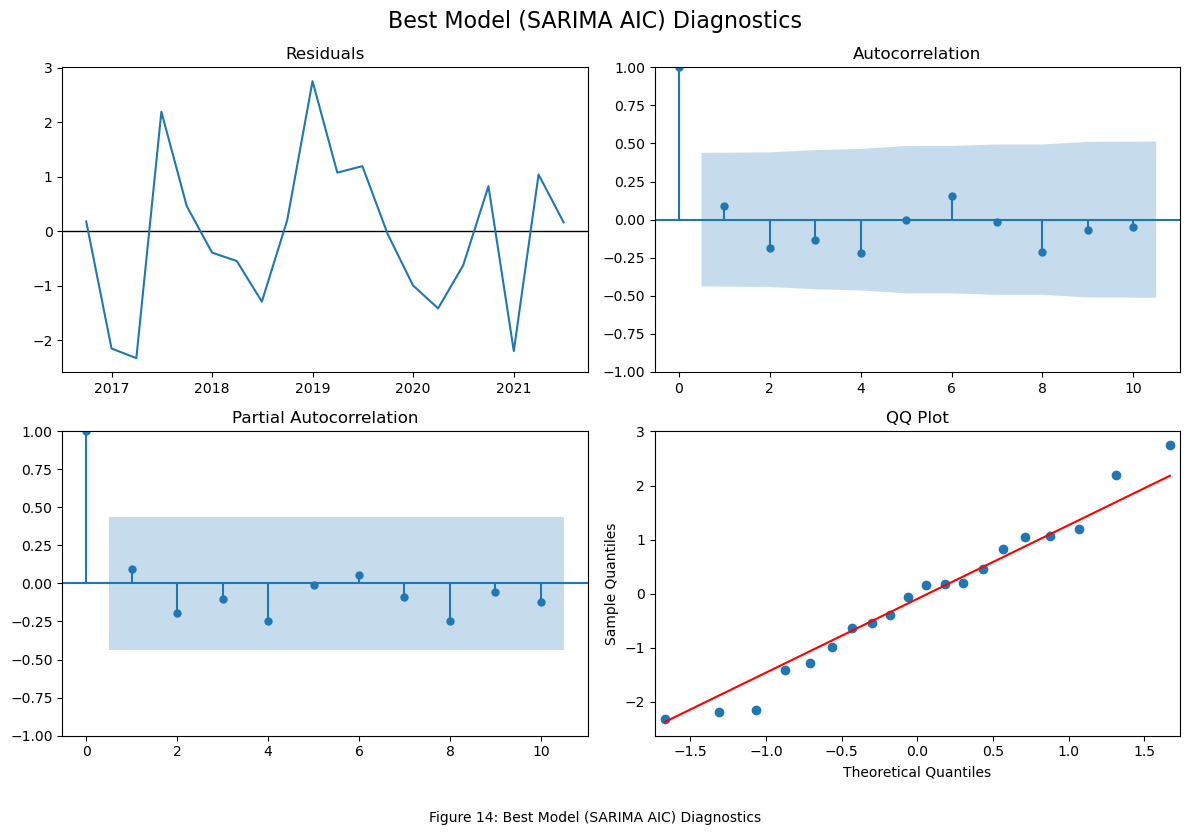

In [43]:
residuals_best_model = sarima_aic_model_.resid()

if isinstance(residuals_best_model.index, pd.PeriodIndex):
    residuals_best_model.index = residuals_best_model.index.to_timestamp()


# Start from 2017Q1
residuals_best_model = residuals_best_model['2017Q1':]

# Plot residuals manually
fig_resid_best_model, ax_resid_best_model = plt.subplots(2, 2, figsize=(12, 8))
fig_resid_best_model.suptitle("Best Model (SARIMA AIC) Diagnostics", fontsize=16)
ax_resid_best_model[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_resid_best_model[0, 0].plot(residuals_best_model)
ax_resid_best_model[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(
    residuals_best_model, ax=ax_resid_best_model[0, 1], alpha=0.05, lags=10)

# PACF plot
sm.graphics.tsa.plot_pacf(
    residuals_best_model, ax=ax_resid_best_model[1, 0], alpha=0.05, lags=10)

# QQ plot
sm.qqplot(residuals_best_model, line='s', ax=ax_resid_best_model[1, 1])
ax_resid_best_model[1, 1].set_title("QQ Plot")

fig_resid_best_model.text(0.5, -0.03, "Figure 14: Best Model (SARIMA AIC) Diagnostics",
                            ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

The diagnostic plots in **Figure 14** for the best model, SARIMA (AIC), follows a relatively same pattern as the SARIMA (AIC) model diagnosis in **Figure 9**.

The residuals plot shows that residuals fluctuate around zero, indicating stationarity, though there are occasional spikes through the 4 years that may signify outliers or unmodeled variance.

The ACF and PACF plots indicate that most autocorrelations fall within the 95% confidence interval, with no significant autocorrelation evident at any lag and a lack of substantial partial autocorrelation at specific lags.  This shows that the model successfully captured the data's patterns over time, since there were no big spikes indicating any leftover dependencies.

The QQ plot shows that residuals are approximately normally distributed, though with slight deviations at the right tail, indicating minor positive skewness and possible outliers.

Overall, the SARIMA (AIC) model is well-fitted, with residuals that are largely uncorellated and close to normal. Minor adjustments can help reduce the occasional spikes and minor autocorrelation. In saying that, this model is the best model for forecasting the future CPI inflations.

# Picking Best Model for Forecasting

In [44]:
best_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                      suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)

horizon = 8

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    best_model.predict(n_periods=horizon), index=test).round(4)

pred.index = pred.index.strftime('%b-%y')

CPI_forecast = pd.DataFrame(pred, columns=['CPI'])
CPI_forecast.index.name = 'Quarter'
CPI_forecast.to_csv('CPI_forecast.csv')

CPI_forecast

,CPI
Quarter,
Mar-22,125.8202
Jun-22,125.8620
Sep-22,126.4599
Dec-22,127.0937
Mar-23,126.9271
Jun-23,127.2465
Sep-23,127.9111
Dec-23,128.1975


# Conclusion

In conclusion, this project has developed a comprehensive time series forecasting model for the Australian Consumer Price Index, utilising rigorous exploratory analysis, model development, and validation techniques. The selected SARIMA model, identified as the most effective in minimising forecasting error, provides accurate CPI projections from March 2022 to December 2023.

These forecasts serve as valuable tools for economic and financial stakeholders, enabling more informed decision making in areas affected by inflationary trends. This project not only demonstrates the effectiveness of SARIMA in capturing CPI dynamics but also establishes a reliable foundation for future CPI forecasts, ensuring adaptability to evolving data and changing economic conditions.

# Code Chunk to Run Tests for Predictions

In [52]:
CPI_test = pd.read_csv('CPI_test.csv')
test_error = mean_squared_error(CPI_test['CPI'], CPI_forecast['CPI'])
print (test_error)

# References

Treasury Ministers (2021) December 2008 Consumer Price Index, December 2008 Consumer Price Index | Treasury Ministers. Treasury Ministers. Available at: https://ministers.treasury.gov.au/ministers/wayne-swan-2007/media-releases/december-2008-consumer-price-index#:~:text=The%20fall%20in%20the%20December,the%20latter%20part%20of%202008. (Accessed: 22 October 2024).